## Car Plate Detector
> PART 1

<img src="example.jpeg" width="500">


### Teaching a NN to "read" symbols from the image

 * generate randomized images of different scales using PIL librabry
 * train a network to detect each symbol separately 

## Generate an image with a symbol



In [45]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
from matplotlib import pyplot as plt


SIZE = (100,100)
ANGLES = [ -6, -3 , 0, 3, 6]
CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-. "
CHARS_LEN = len(CHARS)
FONTS = ["arial", "courier", "times"]


def generateCharacter(char, size, color, bgColor, fontName, angle = 0):
    # GENERATE AN IMAGE WITH A SINGLE CHARACTER

    img = Image.new(mode="L", size = size, color = bgColor)
    draw = ImageDraw.Draw(img)

    font = ImageFont.truetype(f"./fonts/{fontName}.ttf", int(size[1] * 0.8))

    draw.text((15,5), char, fill=color, font=font)

    img = img.rotate(angle)

    return img
# img.show()


def charToOneHot(char):
    index = CHARS.index(char)
    length = CHARS_LEN
    one_hot_vector = [0 for _ in range(index)] + [1] + [0 for _ in range(length - index - 1)]
    return one_hot_vector



In [45]:
# img1 = generateCharacter("y", SIZE, 255, 0, "courier", 45)

# plt.figure()
# plt.imshow(img1)
# img2 = generateCharacter("y", SIZE, 255, 0, "times")

# plt.figure()
# plt.imshow(img2)

# img3 = generateCharacter("y", SIZE, 255, 0, "arial")

# plt.figure()
# plt.imshow(img3)

# print(charToOneHot("."))
# print(len(charToOneHot(".")))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
64


## Create The Dataset

In [48]:
import numpy as np

data_x = None
data_y = None

i = 0
for angle in ANGLES:
    for font in FONTS:
        for c in CHARS:
            img = generateCharacter(c, SIZE, 255, 0, font, angle)
            if i == 0:
                data_x = np.array([np.array(img)])
                data_y = np.array([charToOneHot(c)])
            else:    
                data_x = np.append(data_x, [np.array(img)], axis=0)
                data_y = np.append(data_y, [charToOneHot(c)], axis=0)

            i += 1

for i in range(1000):
    img = np.random.rand(100,100)
    data_x = np.append(data_x, [img], axis=0)
    data_y = np.append(data_y, [charToOneHot(" ")], axis=0)

print(f"generated {data_x.shape} matrix with images")    
print(f"generated {data_y.shape} matrix with labels")    
# print(data_y)
# print(data_x)

generated (1975, 100, 100) matrix with images
generated (1975, 65) matrix with labels


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


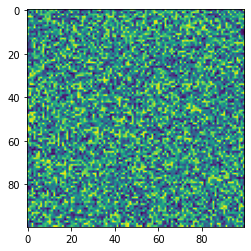

In [50]:
plt.imshow(data_x[1100])
print(data_y[1100])

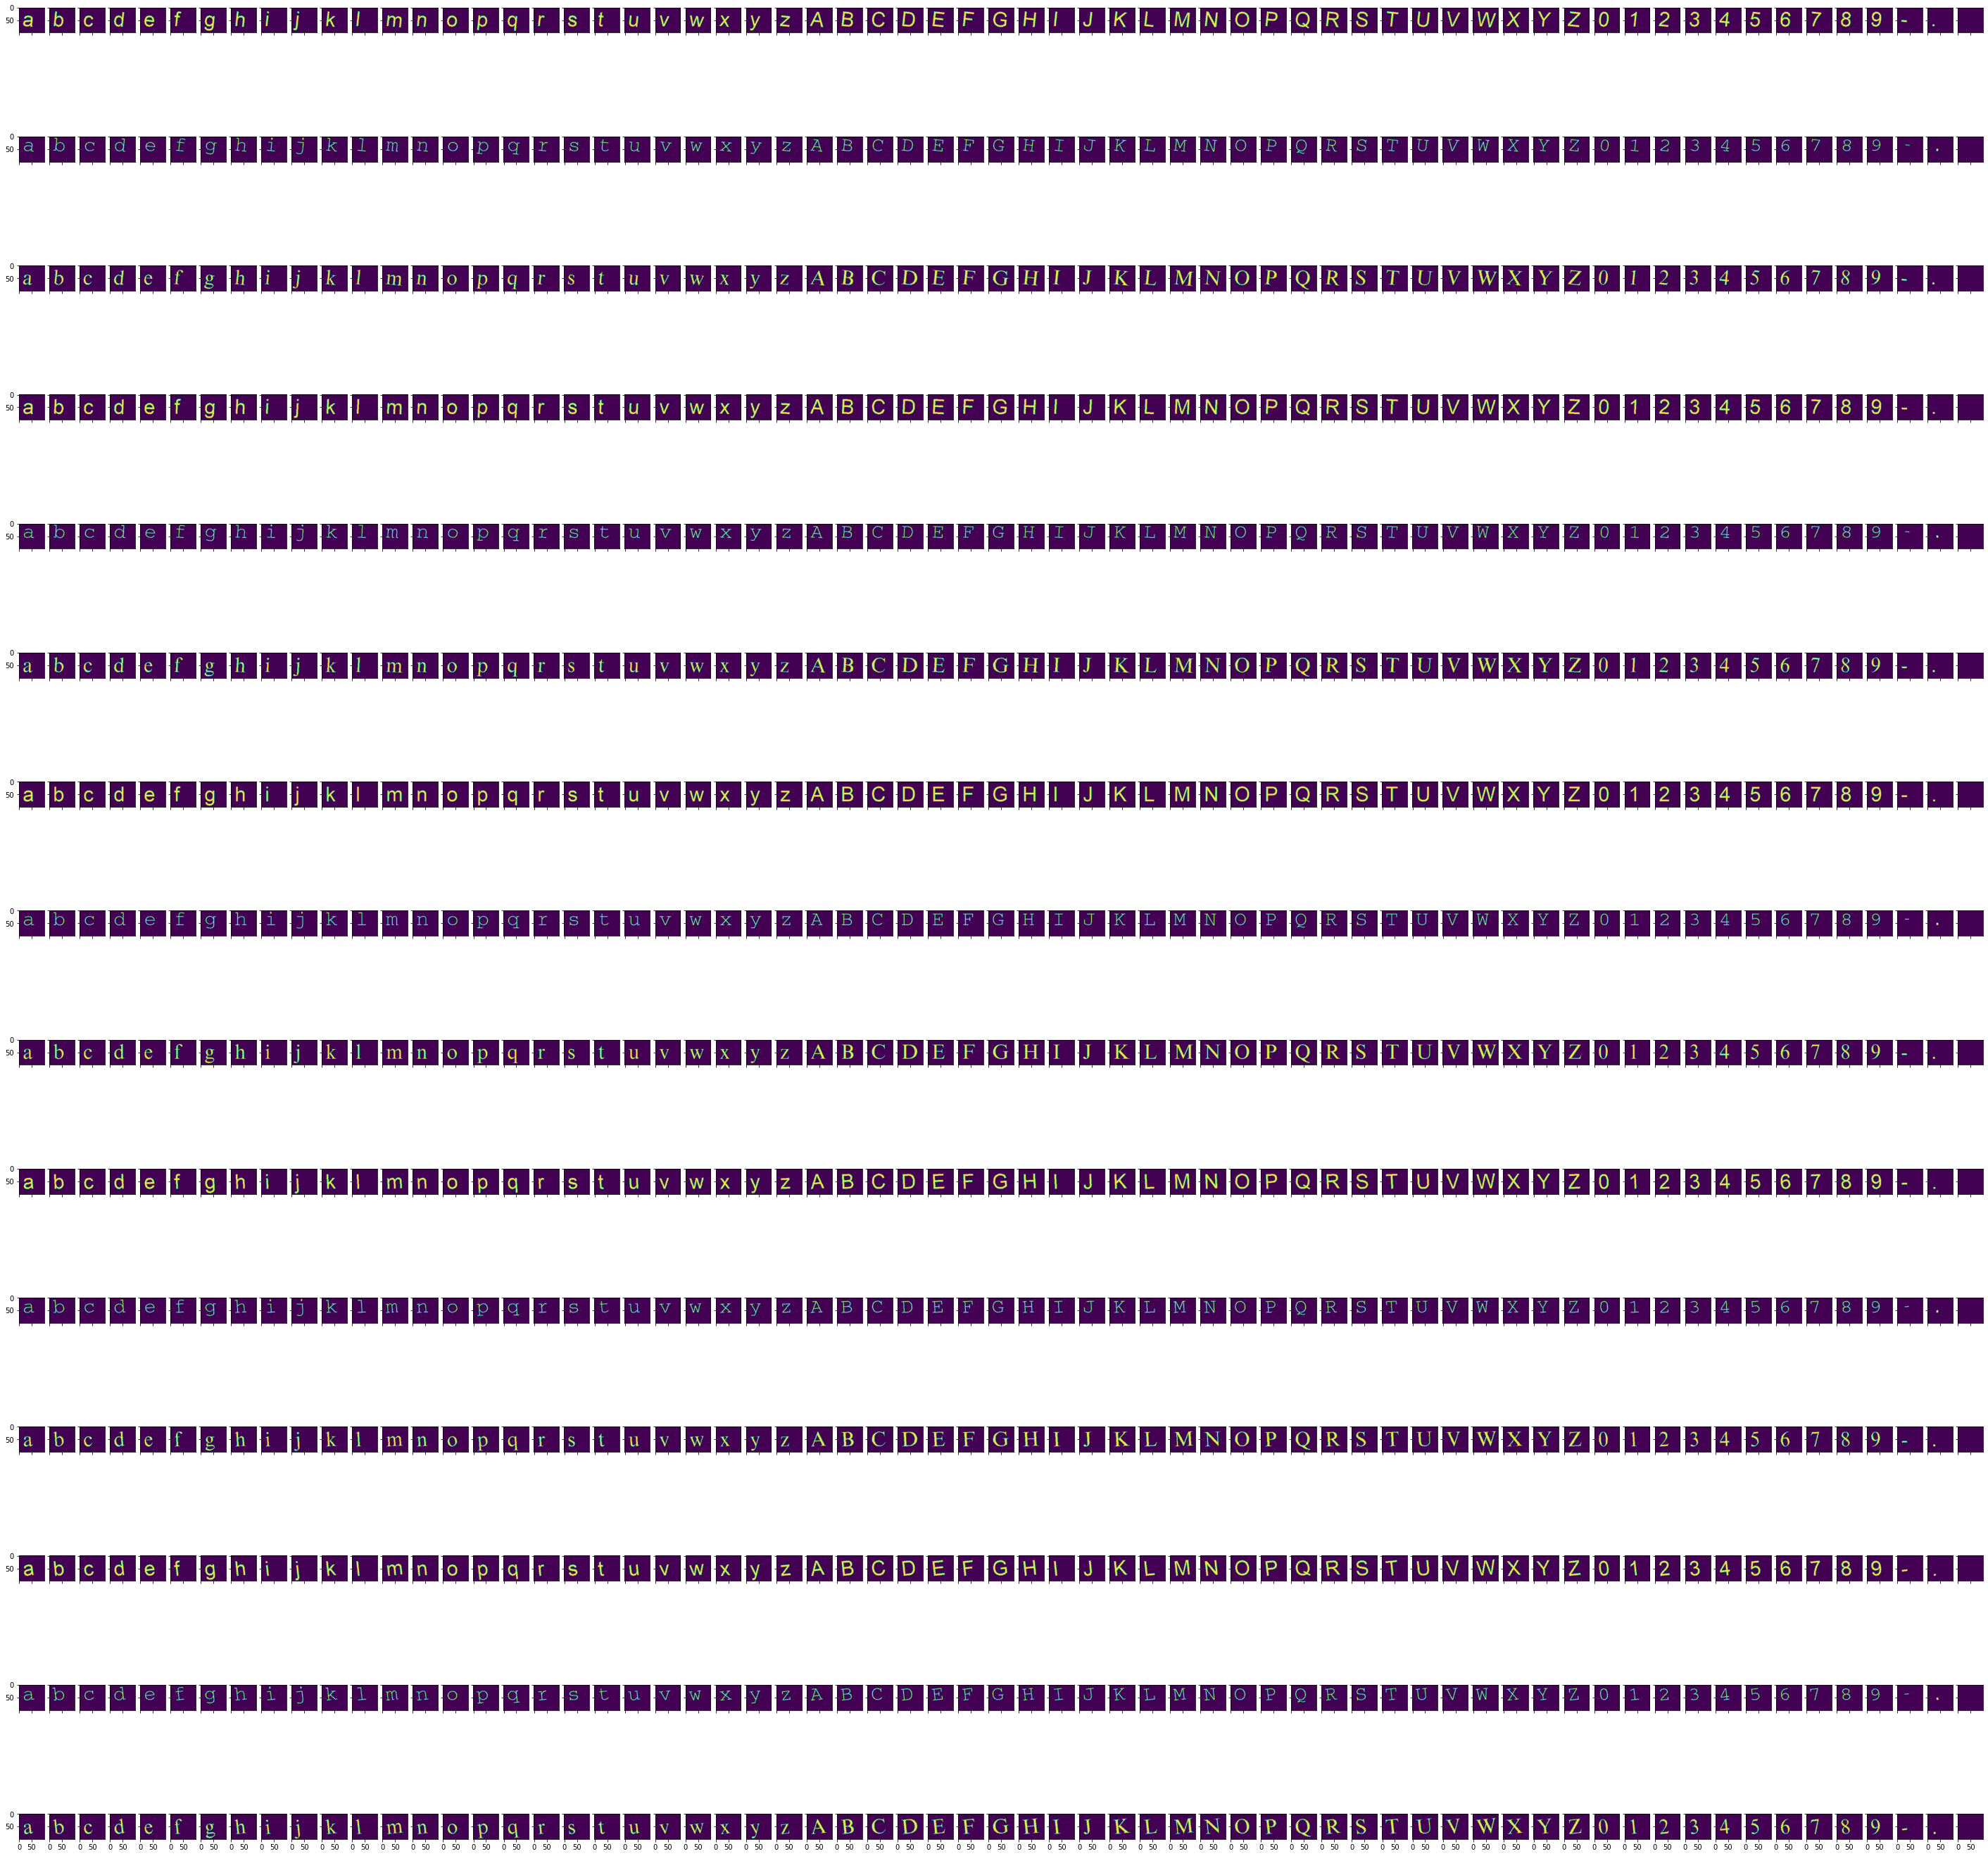

In [47]:
fig = plt.figure(figsize=(50,50))
grid = fig.add_gridspec(15,CHARS_LEN)
axis = grid.subplots(sharex='col', sharey='row')

r = 0
c = 0
for i in range(data_x.shape[0]):

    axis[r,c].imshow(data_x[i])
    c += 1
    if c == CHARS_LEN:
        r += 1
        c = 0

plt.show()
# print(axis)
# for x in data_x:
#     plt.figure(figsize=(1,1))
#     plt.imshow(x)

## One HOT ENCODING

In [ ]:
alphabet = ['a', 'b', 'c']

#[
#  [1,0,0], - a
#  [0,1,0], - b
#  [0,0,1], - c
# ]

## Create a basic NN

 input 100x100    ---> CNN(64 x 100x100) ----> DNN(64 x 512) ----> LNN(512 x 64) ----> output 64  
     

In [51]:
import torch, torch.nn as nn, torch.optim as optim


model = nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=CHARS_LEN, kernel_size=(100,100)),
    nn.Flatten(start_dim=0),
    nn.Linear(in_features=CHARS_LEN, out_features=512),
    nn.Sigmoid(),
    nn.Linear(in_features=512, out_features=CHARS_LEN),
)

## Pass one sample through the NN

In [27]:
x = torch.from_numpy(data_x[1]).type(torch.FloatTensor).view(1,100,100)
# plt.imshow(x)
print(x.shape)

y = torch.argmax(model(x))

print(CHARS[y])

torch.Size([1, 100, 100])
R


## Training loop

In [52]:
criterion  = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(1,101):
    avg_loss = 0
    print(f"epoch {epoch:5} started ...", end="")
    for i in range(len(data_x)):
        x = torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,100,100)
        y = torch.from_numpy(data_y[i]).type(torch.FloatTensor)

        optimizer.zero_grad()
        yp = model(x)
        loss = criterion(yp, y)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    avg_loss /= len(data_x)        
    print(f" finished {avg_loss:f}")    
    # break

epoch     1 started ... finished 0.089814
epoch     2 started ... finished 0.049060
epoch     3 started ... finished 0.047570
epoch     4 started ... finished 0.046596
epoch     5 started ... finished 0.045636
epoch     6 started ... finished 0.044752
epoch     7 started ... finished 0.043935
epoch     8 started ... finished 0.043244
epoch     9 started ... finished 0.042564
epoch    10 started ... finished 0.041939
epoch    11 started ... finished 0.041337
epoch    12 started ... finished 0.040806
epoch    13 started ... finished 0.040309
epoch    14 started ... finished 0.039835
epoch    15 started ... finished 0.039354
epoch    16 started ... finished 0.038942
epoch    17 started ... finished 0.038486
epoch    18 started ... finished 0.038110
epoch    19 started ... finished 0.037675
epoch    20 started ... finished 0.037299
epoch    21 started ... finished 0.036925
epoch    22 started ... finished 0.036518
epoch    23 started ... finished 0.036153
epoch    24 started ... finished 0

## Estimate accuracy

In [53]:

accuracy = 0
print("estimating accuracy ", end="")
for i in range(len(data_x)):
    x = torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,100,100)
    y = torch.from_numpy(data_y[i]).type(torch.FloatTensor)
    yp = model(x)

    if torch.argmax(y) == torch.argmax(yp):
        accuracy += 1


accuracy = 100 * accuracy / len(data_x)

print(f" = {accuracy} %")


estimating accuracy  = 100.0 %


## Manual test

' '


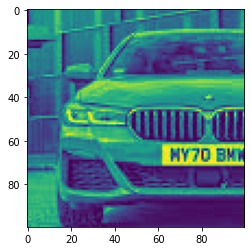

In [59]:
# img = generateCharacter(",", SIZE, 255, 0, "arial", 0)
img = Image.open("images/i1.jpeg")
img = ImageOps.grayscale(img)
img = np.array(img)
img = img[50:150,50:150]
# print(img.shape)
plt.imshow(img)
x = torch.from_numpy( np.array(img) ).type(torch.FloatTensor).view(1,100,100)
y = model(x)
print(f"'{CHARS[torch.argmax(y)]}'")

## Scanning Each 100x100 sector -> building the map

In [66]:
matrix = []
img = Image.open("images/i2.jpg")
img = ImageOps.grayscale(img)
img = np.array(img)

for r in range(180):
    row = []
    for c in range(280):

        imgs = img[r*10:r*10+100,c*10:c*10+100]
        # print(img.shape)
        # plt.figure()
        # plt.imshow(imgs)
        x = torch.from_numpy( np.array(imgs) ).type(torch.FloatTensor).view(1,100,100)
        y = model(x)
        c = CHARS[torch.argmax(y)]
        row.append(c)
        if c != ' ':
            print(c)
    matrix.append(row)    

print(matrix)

[[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '